In [682]:
import cv2
import os
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from models import WormClassifier, WormDataLoader, pre_process_img
from tod import CSV_Reader, WormViewer


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams["figure.figsize"] = (20,5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [750]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

model = WormClassifier()
model.load_state_dict(torch.load("weights/best-model.pt", map_location=device))
# model.load_state_dict(torch.load("weights/best_model_mask.pt", map_location=device))

cpu


<All keys matched successfully>

In [827]:
csv_path = "./exp/csvs/1049.csv"
vid_path = "./exp/vids/1049.avi"

viewer = WormViewer(csv_path, vid_path)
frame, bbs = processer.get_worms_from_frame(2000)


Determining Experiment End


100%|██████████| 25/25 [00:00<00:00, 36.83it/s]


Experiment Done @ Frame 1900


In [828]:
def draw_from_output(img, outputs, col=(255,255,0), text=None):
    """ Img is cv2.imread(img) and outputs are (x1, y1, x2, y2, conf, cls_conf)
    Returns the image with all the boudning boxes drawn on the img """
    for output in outputs:
        # output = [float(n) for n in output]
        x1, y1, w, h= output
        x1, y1, x2, y2 = int(x1), int(y1), int(x1 + w), int(y1 + h)
        cv2.rectangle(img, (x1,y1), (x2,y2), col, 2)

        if text is not None:
            cv2.putText(img, f"{round(float(conf), 3) : }{text}",
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

            
# Helper Functions
def get_worms(image, bbs):
    """ Takes image and list of bbs and returns a list of the
    cutouts for each worm"""
    worms = []
    for bb in bbs:
        bb = bb.astype(int)
        x, y, w, h = bb
        worm = image[y:y+h, x:x+w]
        worms.append(worm)
    
    return worms


def display_worms(worms: list[np.ndarray]):
    """List of worm images and then makes a figure with all
    the worms"""
    worm_count = len(worms)
    fig = plt.figure()
    
    for i in range(worm_count):
        fig.add_subplot(1, worm_count, i + 1)
        plt.imshow(worms[i])
    
    plt.show(block=True)

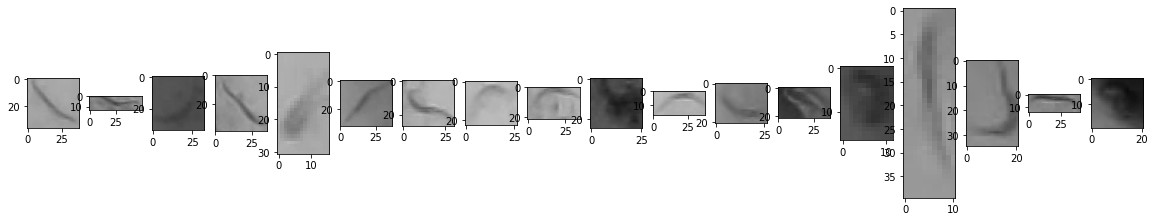

In [829]:
worm_ids = np.arange(0, len(viewer.tracked))
end_worms = viewer.fetch_worms(worm_ids, 2200)
new_worms = viewer.fetch_worms(worm_ids, 1600)


display_worms(end_worms)
# plt.imshow(end_worms[0])

## Now pass the worm images through the model.


In [830]:
worm_ids = np.arange(0, len(viewer.tracked))
end_worms = viewer.fetch_worms(worm_ids, 1900)
new_worms = viewer.fetch_worms(worm_ids, 1600)

def get_img_features(img):
    img = pre_process_img(img)
    x, feat = model.forward(img, features=True)
    feat = feat.detach().numpy()[0]
    return x, feat

_, worm0 = get_img_features(end_worms[10])

distances = []
classes = []

new_copy = new_worms.copy()

for w in new_copy: 
    x, feat = get_img_features(w)
    dist = np.linalg.norm(worm0 - feat)
    distances.append(dist)
    classes.append(x)
    
min_dst = np.argmin(distances)
print(min_dst)
print(distances[min_dst])
print(_, classes[min_dst])
# print(np.argmin(distances))
    
#     output = 1 if output > 0.5 else 0
# print(distances)
print(classes[5])
print(distances)

7
75.078415
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]], grad_fn=<SigmoidBackward>)
tensor([[1.]], grad_fn=<SigmoidBackward>)
[114.70117, 96.94516, 137.22925, 78.3287, 106.63451, 94.582596, 130.8453, 75.078415, 138.17308, 197.16794, 200.96576, 132.76097, 189.1943, 110.91713, 139.3493, 171.85071, 182.03871, 97.35131]


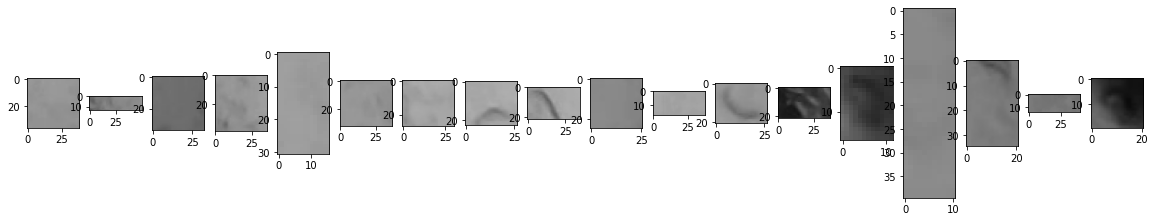

In [897]:
new_worms = viewer.fetch_worms(worm_ids, 1300)
display_worms(new_worms)

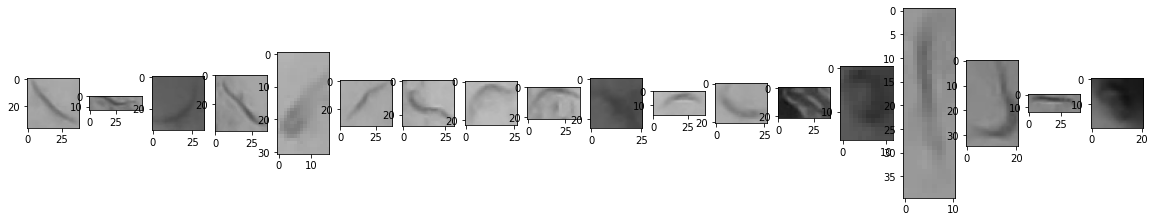

In [832]:
display_worms(end_worms)

In [838]:
viewer = WormViewer(csv_path, vid_path)

worm_imgs = []
for frame_id in tqdm(range(2400, 300, -10)):
    _, frame = viewer.get_frame(frame_id)
    viewer.update_tracked(frame_id, thresh=0.5)
  
    if frame_id % 20 == 0:
        w = viewer.fetch_worms([4], frame_id)[0]
        worm_imgs.append(w)
        
#     for bb in viewer.tracked:
#         x, y, w, h = bb
#         cv2.rectangle(frame, (int(x),int(y)), (int(x+w), int(y+h)), (0,255,255), 2)

Determining Experiment End


100%|██████████| 25/25 [00:00<00:00, 36.88it/s]


Experiment Done @ Frame 1900


100%|██████████| 210/210 [00:07<00:00, 26.79it/s]


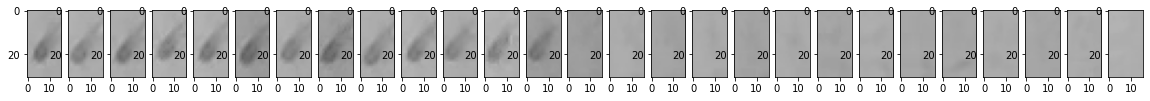

In [839]:
display_worms([worm_imgs[i] for i in range(0, len(worm_imgs), 4)])

In [889]:

distances = []
classes = []

for i, w in enumerate(worm_imgs):
    ref = max(0, i-10)
    _, worm0 = get_img_features(worm_imgs[0])
    
    x, features = get_img_features(w)
    dist = np.linalg.norm(worm0 - features)
    distances.append(dist)
    if x[0][0] < 0.5:
        classes.append(0)
    else:
        classes.append(1)
#     classes.append(x.to(int)[0][0])
    

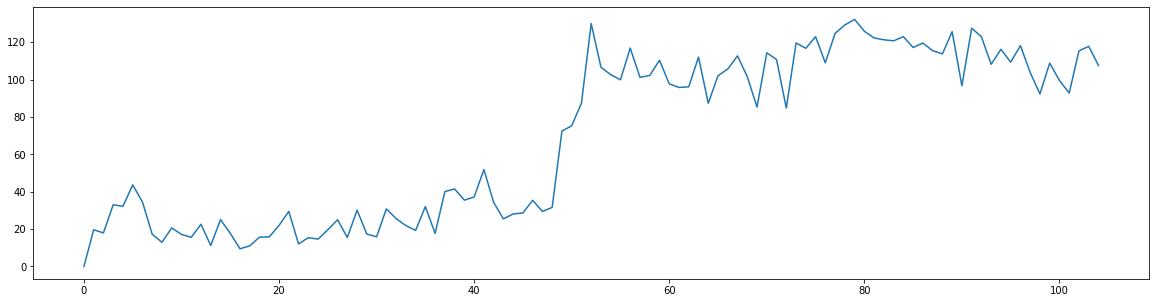

In [890]:
plt.plot(distances)

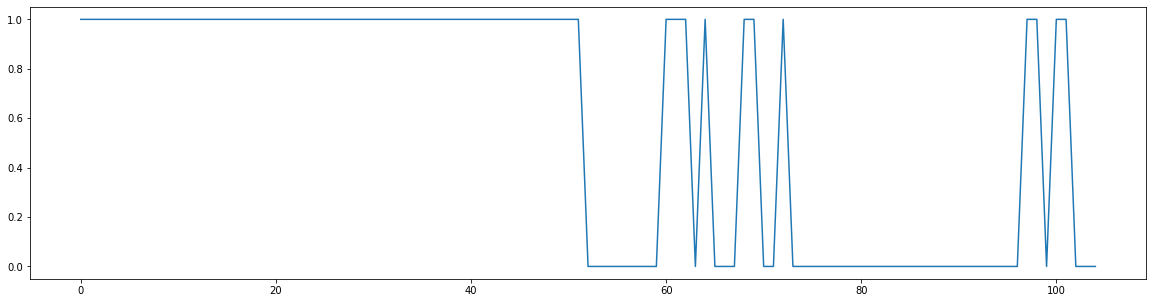

In [891]:
plt.plot(classes)

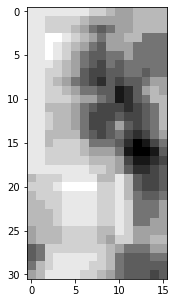

In [919]:
plt.imshow(new_worms[4])
test = pre_process_img(new_worms[8])

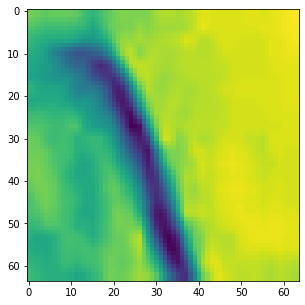

In [920]:
plt.imshow(test.squeeze(1).view(64,64,1))
